In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [9]:
file_finished = "data/wikispeedia_paths-and-graph/paths_finished.tsv"
column_names = ["hashedIpAddress", "timestamp", "durationInSec", "path", "rating"]
finished_paths = pd.read_csv(file_finished, sep="\t", comment="#", names=column_names)

In [10]:
# Split the path into a list
finished_paths["path"] = finished_paths["path"].apply(lambda x: x.split(";"))

# Count the number of clicks in each path (including back clicks)
finished_paths = finished_paths.assign(nb_clicks=finished_paths["path"].apply(lambda x: len(x)-1)) # -1 because we don't count the source article

# Count the number of back clicks in each path
finished_paths = finished_paths.assign(nb_back_clicks=finished_paths["path"].apply(lambda x: x.count("<")))

# Count the path length (excluding back clicks)
finished_paths = finished_paths.assign(path_length=finished_paths["nb_clicks"] - 2 * finished_paths["nb_back_clicks"])

# Convert the rating to int
finished_paths["rating"] = finished_paths["rating"].fillna(-1).astype(int) #0 means no rating

finished_paths.head(2)

hashedIpAddress   timestamp  durationInSec  \
0  6a3701d319fc3754  1297740409            166   
1  3824310e536af032  1344753412             88   

                                                path  rating  nb_clicks  \
0  [14th_century, 15th_century, 16th_century, Pac...      -1          8   
1  [14th_century, Europe, Africa, Atlantic_slave_...       3          4   

   nb_back_clicks  path_length  
0               0            8  
1               0            4

# TOP 10 PLAYERS

Look at evolution of the 10 players who have played the most. Do they improve over time ?

In [11]:
#group by player defined as the hashed IP address
grouped_players = finished_paths.groupby("hashedIpAddress")

#count the number of paths each player has taken and sort by number of paths in descending order
player_path_counts = grouped_players.size()
player_path_counts = player_path_counts.sort_values(ascending=False)

In [12]:
top10_players = player_path_counts.head(10)

In [13]:
top10_players_plays = finished_paths[finished_paths["hashedIpAddress"].isin(top10_players.index)]

In [14]:
#group by player and rank the paths by the order they were taken
grouped_top10_paths = top10_players_plays.groupby("hashedIpAddress")

ordered_top10_paths = grouped_top10_paths.apply(lambda x: x.sort_values(by="timestamp"))
ordered_top10_paths.head(5)

C:\Users\matis\AppData\Local\Temp\ipykernel_18896\523489472.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ordered_top10_paths = grouped_top10_paths.apply(lambda x: x.sort_values(by="timestamp"))


hashedIpAddress   timestamp  durationInSec  \
hashedIpAddress                                                       
0299542414c3f20a 6416   0299542414c3f20a  1257544042             73   
                 32404  0299542414c3f20a  1257544323            180   
                 45145  0299542414c3f20a  1257544466             99   
                 44530  0299542414c3f20a  1257544820             80   
                 33966  0299542414c3f20a  1257888014             65   

                                                                     path  \
hashedIpAddress                                                             
0299542414c3f20a 6416   [Music_of_Barbados, Sugarcane, Japan, Japanese...   
                 32404  [Sean_Connery, Edinburgh, Engineering, Science...   
                 45145           [Pikachu, Continent, Nile, River, Flood]   
                 44530  [Otter, California, Mexico, Hern%C3%A1n_Cort%C...   
                 33966        [Addis_Ababa, Italy, Brazil, Latin_America]   

                        rating  nb_clicks  nb_back_clicks  path_length  
hashedIpAddress                                                         
0299542414c3f20a 6416        2          4               0            4  
                 32404       4          8               0            8  
                 45145       2          4               0            4  
                 44530       3          5               0            5  
                 33966       3          3               0            3

Text(0, 0.5, 'Path length')

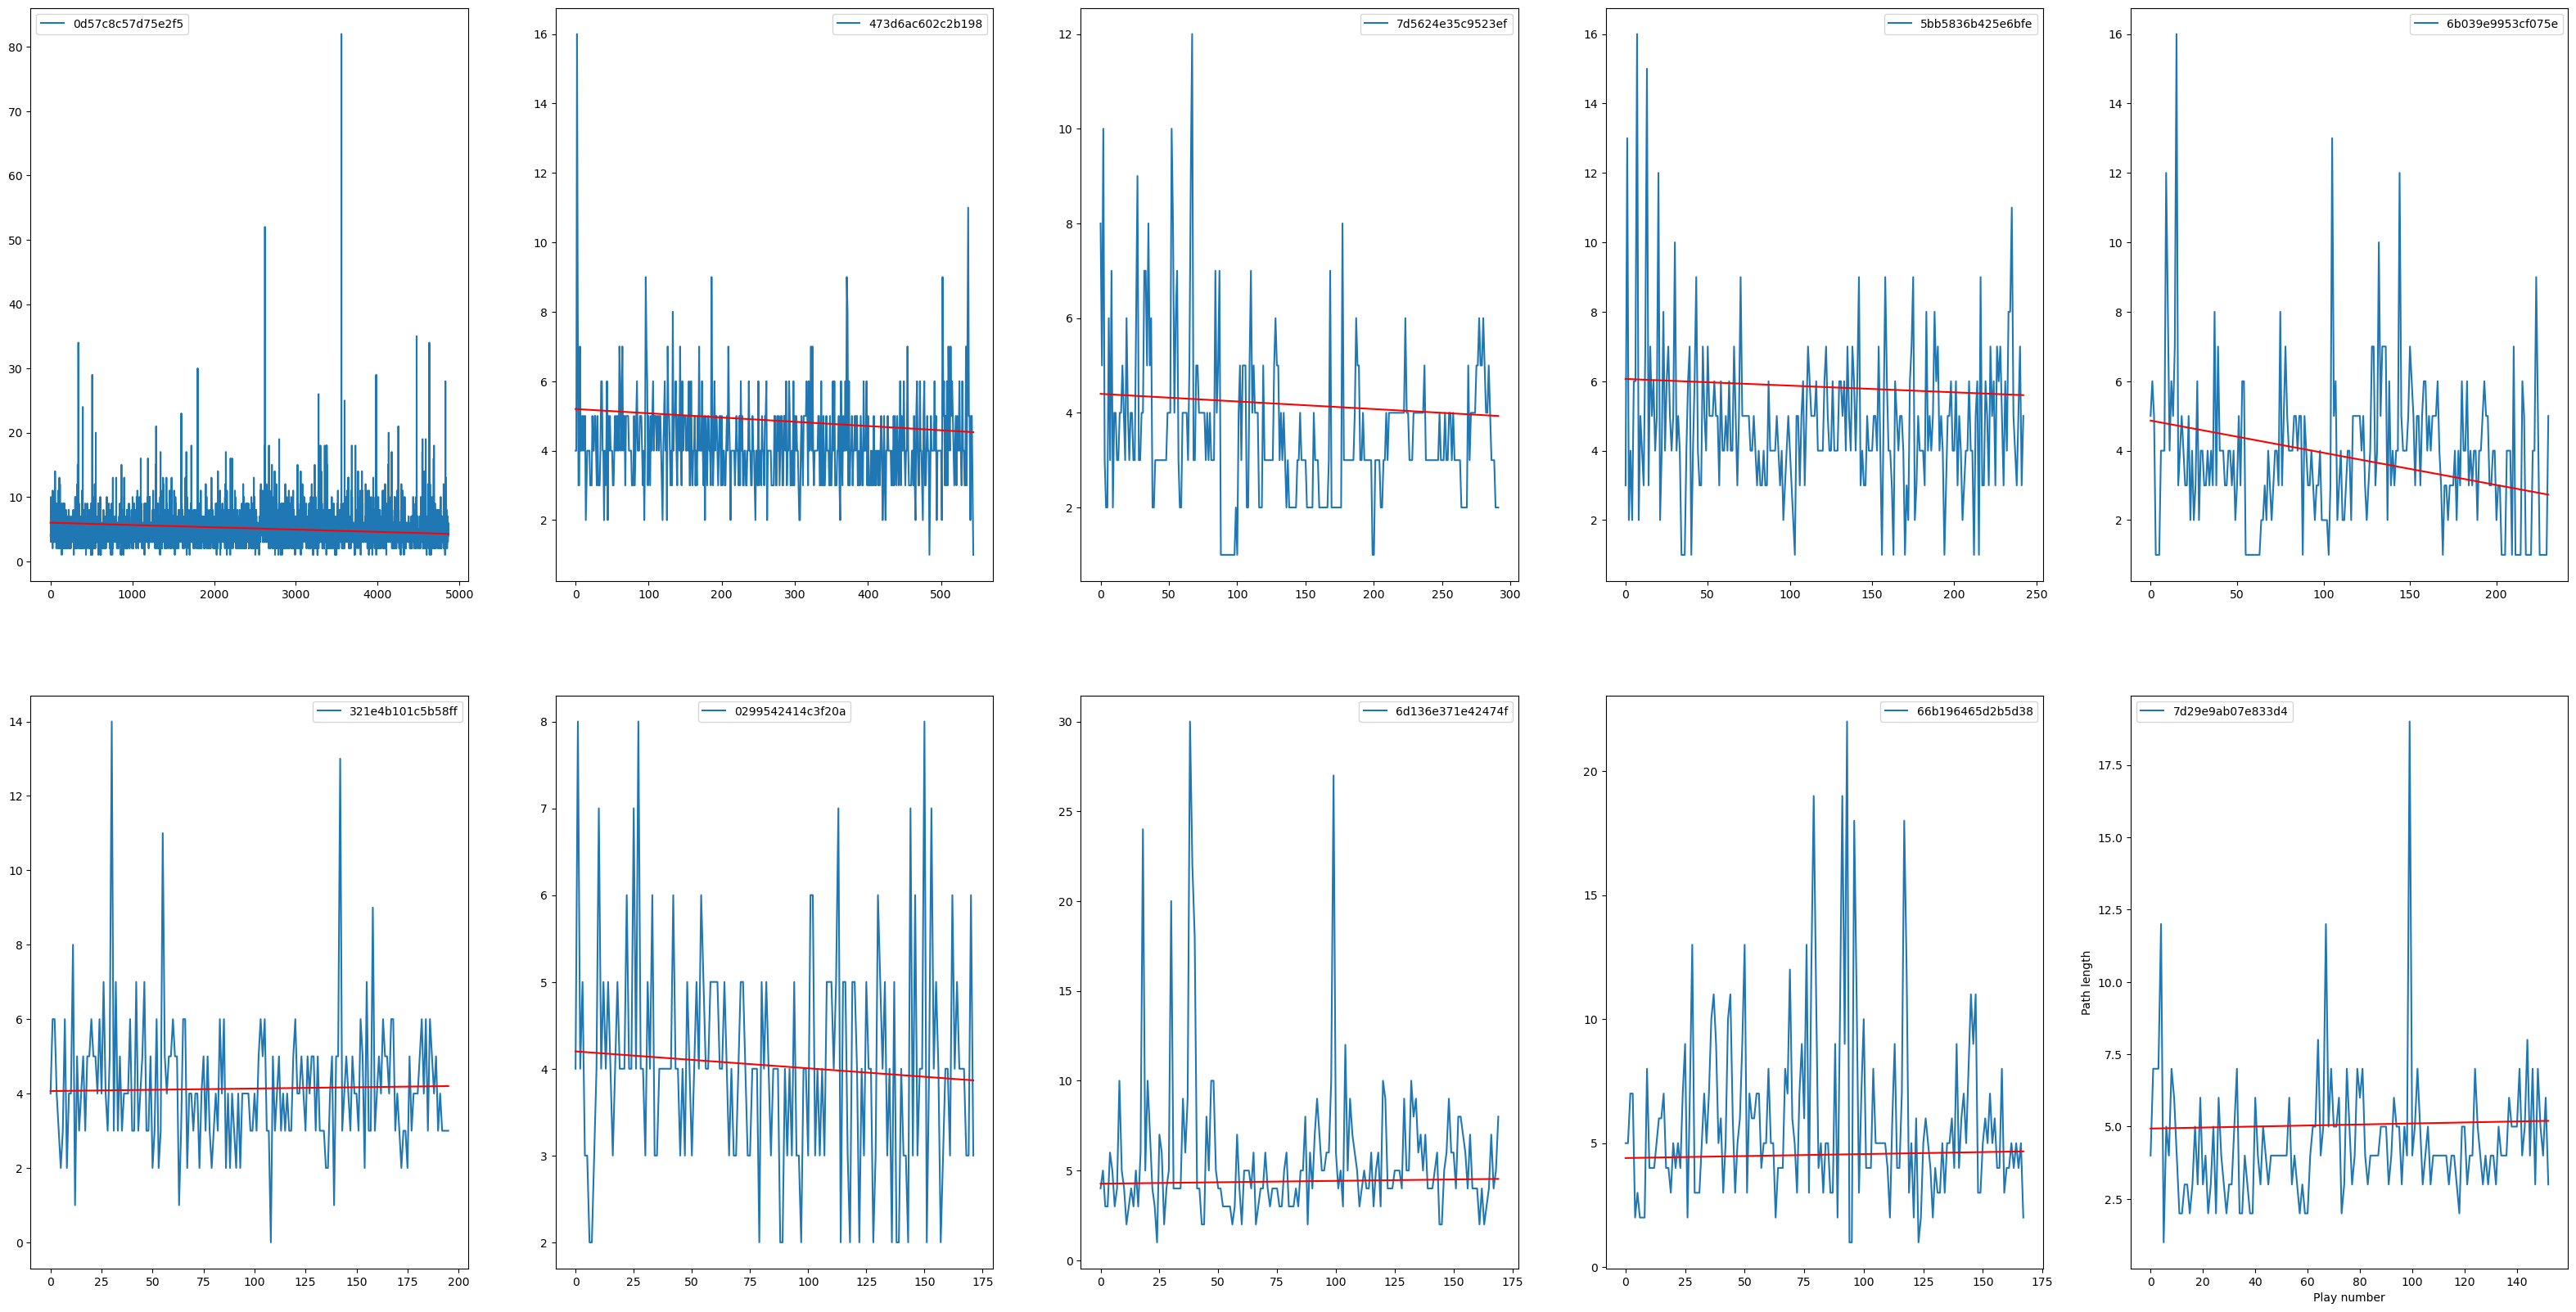

In [15]:
fig, axs = plt.subplots(2,5,figsize=(40, 20))
for i in range(10) :
    player = top10_players.index[i]
    player_paths = ordered_top10_paths.loc[player]
    path_lenghts = player_paths["path_length"]
    path_lenghts.index = range(len(path_lenghts))
    row = i // 5
    col = i % 5
    ax = axs[row, col]
    path_lenghts.plot(ax=ax, label=player, legend=True)
    slope = [path_lenghts[0:15].mean(),path_lenghts[-15:].mean()]
    ax.plot([0,len(path_lenghts)-1],[slope[0],slope[1]], label="slope", color="red")


plt.xlabel("Play number")
plt.ylabel("Path length")

    


# IS GEOGRAPHY THE SOLUTION ?

To compare let's start by finding the most common pair of s-t 

In [16]:
#add start and end node of each path to the dataframe
finished_paths['(s,t)'] = finished_paths.apply(lambda x: (x['path'][0], x['path'][-1]), axis=1)
finished_paths['source' ] = finished_paths.apply(lambda x: x['(s,t)'][0], axis=1)
finished_paths['target'] = finished_paths.apply(lambda x: x['(s,t)'][1], axis=1)
finished_paths.head(2)

hashedIpAddress   timestamp  durationInSec  \
0  6a3701d319fc3754  1297740409            166   
1  3824310e536af032  1344753412             88   

                                                path  rating  nb_clicks  \
0  [14th_century, 15th_century, 16th_century, Pac...      -1          8   
1  [14th_century, Europe, Africa, Atlantic_slave_...       3          4   

   nb_back_clicks  path_length                                (s,t)  \
0               0            8  (14th_century, African_slave_trade)   
1               0            4  (14th_century, African_slave_trade)   

         source               target  
0  14th_century  African_slave_trade  
1  14th_century  African_slave_trade

In [17]:
#find the 10 most common combinations of start and end nodes
most_common_paths = finished_paths['(s,t)'].value_counts().head(10)
most_common_paths

(s,t)
(Asteroid, Viking)           1043
(Brain, Telephone)           1040
(Theatre, Zebra)              905
(Pyramid, Bean)               642
(Batman, Wood)                148
(Bird, Great_white_shark)     138
(Batman, The_Holocaust)       119
(Bird, Adolf_Hitler)          107
(Beer, Sun)                    99
(Batman, Banana)               69
Name: count, dtype: int64

To see if they pass by geography let's convert each node to its corresponding category

In [18]:
categories = pd.read_csv("data/wikispeedia_paths-and-graph/categories.tsv", sep='\t', comment='#')
categories.columns = ["article", "category"]
categories["category"] = categories["category"].apply(lambda x: x.split(".")[1:])
categories.head(2)

article                      category
0  %C3%81ed%C3%A1n_mac_Gabr%C3%A1in  [People, Historical_figures]
1                        %C3%85land                   [Countries]

In [19]:
filtered_paths = finished_paths[finished_paths['(s,t)' ].isin(most_common_paths.index.tolist())]

In [20]:
def get_category(article):
    try:
        return categories[categories["article"] == article]["category"].values[0]
    except:
        return None

In [21]:
#testing function
print(get_category("Aristotle"))

['People', 'Philosophers']


In [22]:
filtered_paths['category_paths'] = filtered_paths['path'].apply(lambda x : [get_category(article) for article in x])

C:\Users\matis\AppData\Local\Temp\ipykernel_18896\1903230909.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_paths['category_paths'] = filtered_paths['path'].apply(lambda x : [get_category(article) for article in x])


In [23]:
filtered_paths['category_paths'].head(2)

1431    [[Everyday_life, Cartoons], [Geography, Geogra...
1432    [[Everyday_life, Cartoons], [Science, Chemistr...
Name: category_paths, dtype: object

In [28]:
def contains_category(x, category):
    if x is None : 
        return False
    for elt in x :
        print(elt)
        if elt is None :
            continue
        if category in elt :
            return True
    return False
        
    

In [25]:
#let's try our function with an imaginary category path
test = [['no', 'yes', 'no'], ['no', 'no', 'no'], ['Geography']]
print(contains_category(test, 'Geography')) #should return True
test = [['no', 'yes', 'no'], ['no', 'no', 'no'], ['History']]
print(contains_category(test, 'Geography')) #should return False
test = [['History', 'Geography']]
print(contains_category(test, 'Geography')) #should return True

['no', 'yes', 'no']
['no', 'no', 'no']
['Geography']
True
['no', 'yes', 'no']
['no', 'no', 'no']
['History']
False
['History', 'Geography']
True


In [ ]:
filtered_paths['Path_has_geography'] = filtered_paths['category_paths'].apply(lambda x: contains_category(x, 'Geography'))


In [32]:
plays_with_geo = filtered_paths[filtered_paths['Path_has_geography'] == True]
plays_without_geo = filtered_paths[filtered_paths['Path_has_geography'] == False]

In [33]:
plays_with_geo.groupby('(s,t)')['path_length'].mean()

(s,t)
(Asteroid, Viking)            6.064236
(Batman, Banana)              6.740741
(Batman, The_Holocaust)       4.271186
(Batman, Wood)                5.883929
(Beer, Sun)                   3.857143
(Bird, Adolf_Hitler)          4.500000
(Bird, Great_white_shark)    11.000000
(Brain, Telephone)            7.904110
(Pyramid, Bean)               7.582222
(Theatre, Zebra)              6.362590
Name: path_length, dtype: float64

In [35]:
plays_with_geo.shape

(1904, 13)

In [34]:
plays_without_geo.groupby('(s,t)')['path_length'].mean()

(s,t)
(Asteroid, Viking)           5.691649
(Batman, Banana)             5.190476
(Batman, The_Holocaust)      4.000000
(Batman, Wood)               4.833333
(Beer, Sun)                  4.227273
(Bird, Adolf_Hitler)         3.980392
(Bird, Great_white_shark)    4.283582
(Brain, Telephone)           5.248190
(Pyramid, Bean)              5.381295
(Theatre, Zebra)             4.919048
Name: path_length, dtype: float64

In [36]:
plays_without_geo.shape

(2406, 13)